Installing and Importing Necessary Libraries

In [1]:
!pip install mediapipe

INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 23.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 21.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Successfully uninstalled opencv-contrib-python-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 re

In [2]:
# !pip install torchcodec
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 19.7 MB/s eta 0:00:0000:0100:01m
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=902c2af5fc3812f87a3cd554a00884b514a2a4d1579106e06fef718f69582225
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=7d38c9a2ca315ac4e5308ad07d565e41005779801a9934df8ce85d1db5e10181
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Crea

In [13]:
import cv2
import mediapipe as mp
import numpy as np
import torch
import os
import json

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Data Importing from Drive

Mediapipe Landmarks Extraction

In [15]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [16]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2
)

In [17]:
def detect_landmarks(image):
    results = holistic.process(image)

    landmarks = {
        'left_hand': None,
        'right_hand': None,
        'pose': None,
        # 'face': None
    }

    if results.left_hand_landmarks:
        landmarks['left_hand'] = results.left_hand_landmarks

    if results.right_hand_landmarks:
        landmarks['right_hand'] = results.right_hand_landmarks

    if results.pose_landmarks:
        landmarks['pose'] = results.pose_landmarks

    # if results.face_landmarks:
    #     landmarks['face'] = results.face_landmarks

    return landmarks

W0000 00:00:1762152640.304552     135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762152640.513913     137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762152640.517795     134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762152640.519118     135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762152640.523347     137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762152640.529281     134 inference_feedback_manager.cc:114] Feedback manager 

In [18]:
def process_frame(frame):
    frame = cv2.resize(frame, (640,480))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    result = detect_landmarks(frame_rgb)

    if result['left_hand']:
      mp_drawing.draw_landmarks(frame, result['left_hand'], mp_holistic.HAND_CONNECTIONS)

    if result['right_hand']:
      mp_drawing.draw_landmarks(frame, result['right_hand'], mp_holistic.HAND_CONNECTIONS)

    if result['pose']:
      mp_drawing.draw_landmarks(frame, result['pose'], mp_holistic.POSE_CONNECTIONS)

    # if result['face']:
    #   mp_drawing.draw_landmarks(frame, result['face'], mp_holistic.FACEMESH_TESSELATION)

    return frame

In [19]:
# fps <= 25
def process_video(video_path, fps=25):
  cap = cv2.VideoCapture(video_path)

  if not cap.isOpened():
    print("Error opening video file:", video_path)
    return None

  frames = []

  total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  step = max(1, 25 // fps)

  for i in range(0, total, step):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()

    if ret:
      frame = process_frame(frame)
      frames.append(frame)

  cap.release()

  return np.array(frames)

In [20]:
data_path = '/kaggle/input/include'
# data_path = '/kaggle/input/isl-csltr-indian-sign-language-dataset/ISL_CSLRT_Corpus/ISL_CSLRT_Corpus/Videos_Sentence_Level'

In [21]:
from matplotlib import pyplot as plt

W0000 00:00:1762152652.390102     136 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


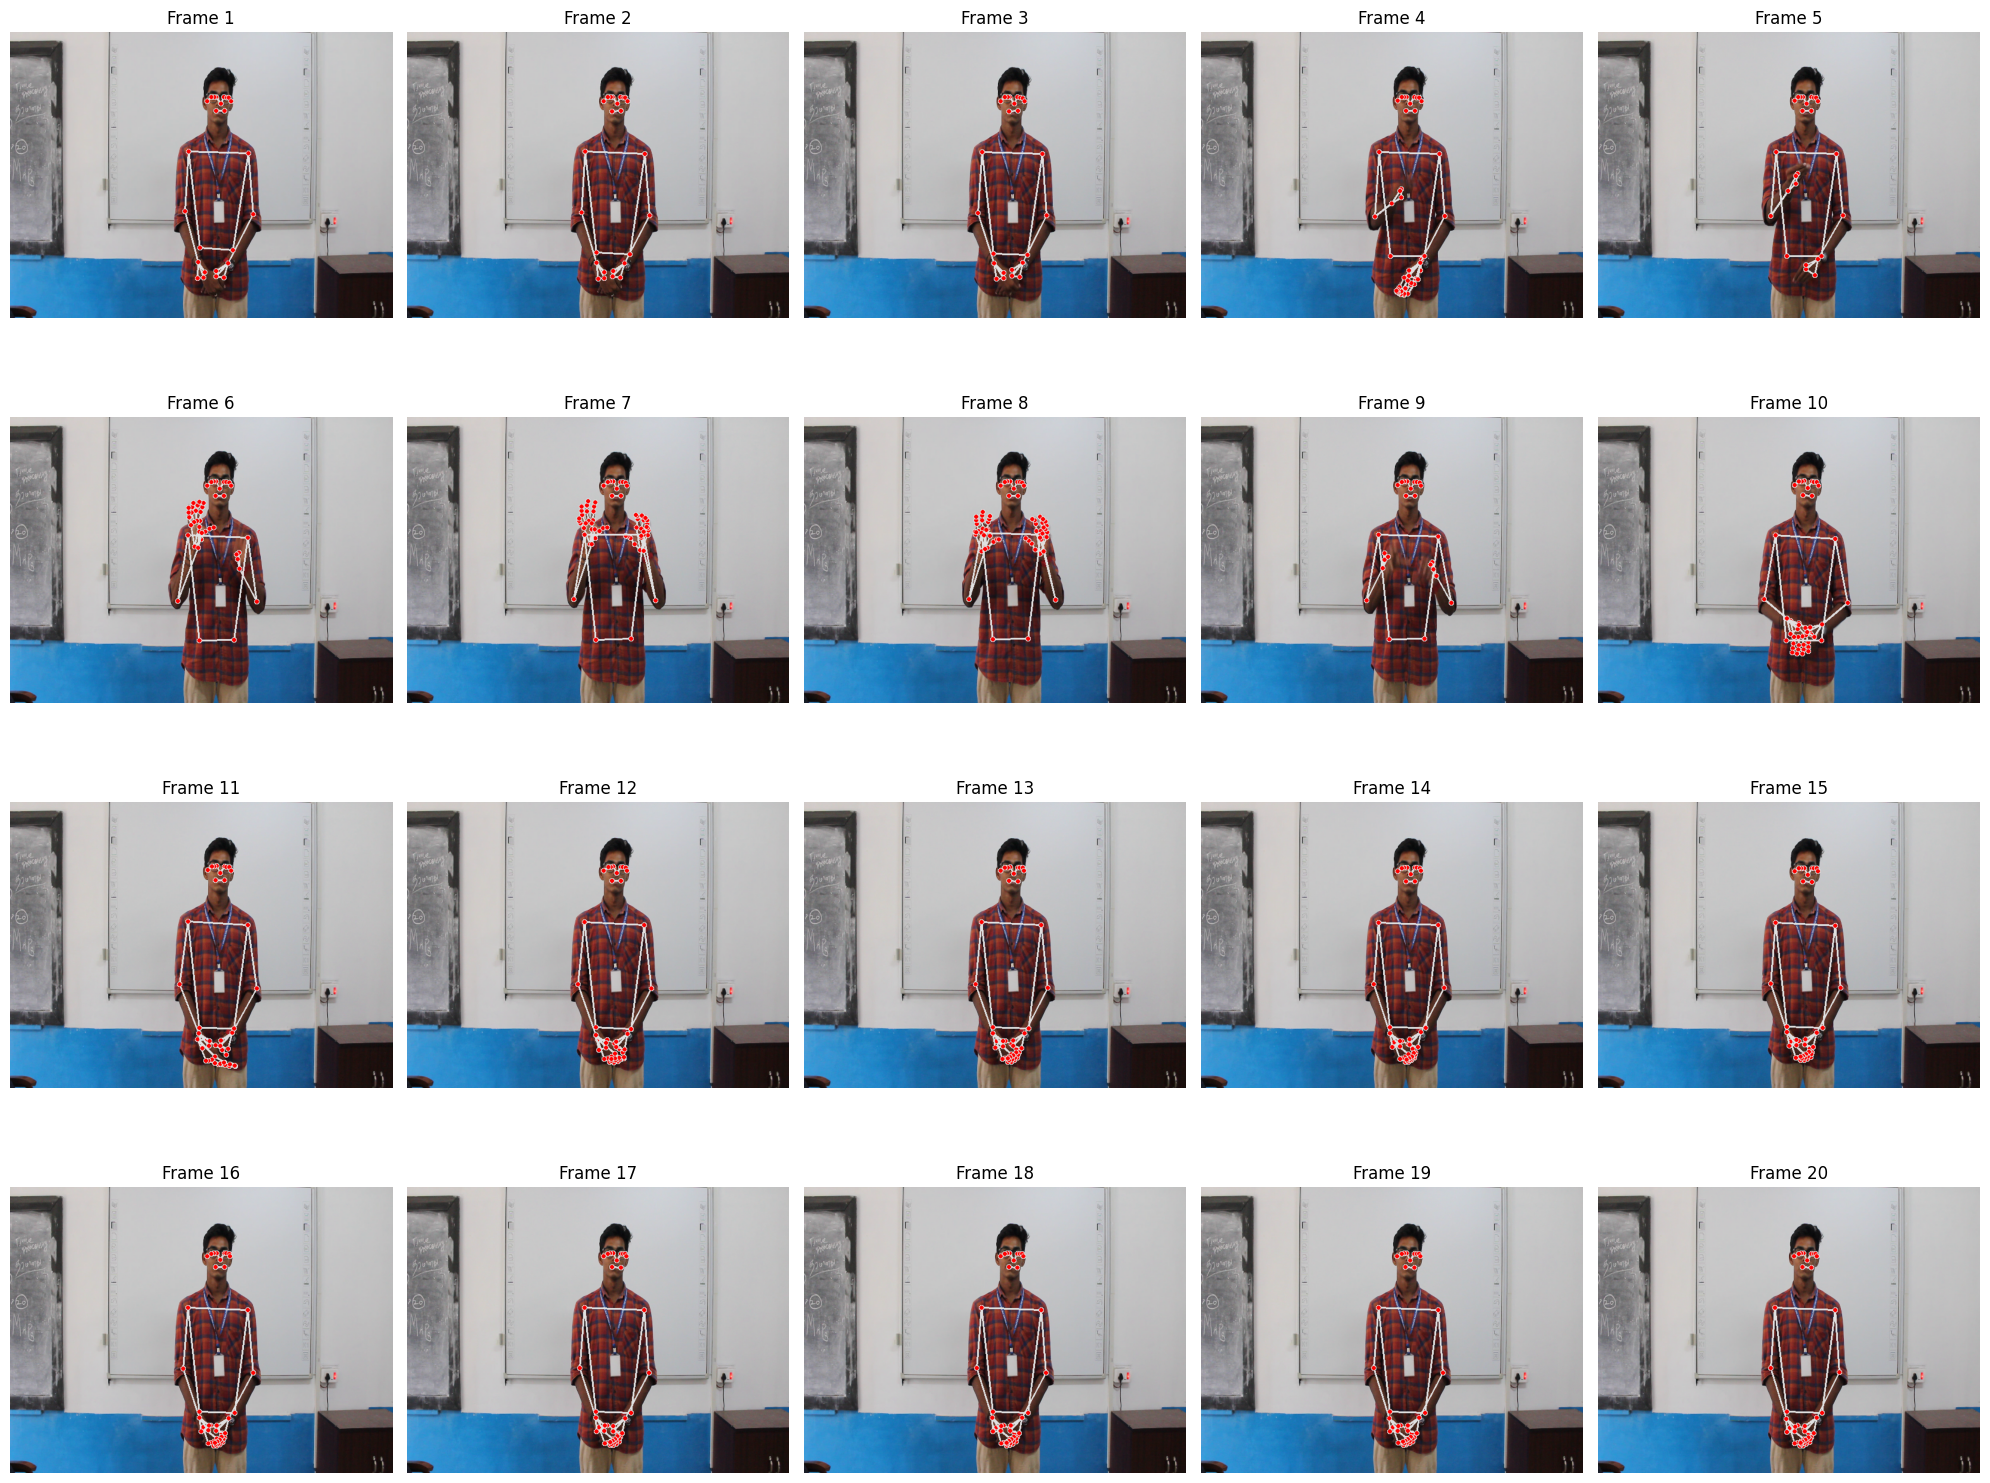

In [22]:
processed_frames = process_video(os.path.join(data_path, 'Animals_1of2/Animals/1. Dog/MVI_2978.MOV'), fps=4)
# processed_frames = process_video(os.path.join(data_path, 'are you free today/free (2).MP4'), fps=4)

# Calculate the number of rows and columns for the grid
num_frames = len(processed_frames)
cols = 5  # You can adjust the number of columns
rows = (num_frames + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))  # Adjust figure size as needed

for i, frame in enumerate(processed_frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [23]:
processed_frames.shape

(20, 480, 640, 3)

In [24]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = process_frame(frame)

    cv2.imshow('Hand Landmarks', frame)
    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@51.812] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@51.813] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


Data Preprocessing and Loading

In [25]:
def path_to_class(path):
  return path.split('/')[-1].split('.')[1].strip() # INCLUDE Dataset
  # return path.split('/')[-1] # ISL-CSLRT Dataset

In [26]:
class_paths = []
for root, _, files in os.walk(data_path):
    if data_path == root or 'extra' in root.lower():
        continue
    if len(files) > 0:
        class_paths.append(root)

classes = [path_to_class(path) for path in class_paths]

# classes = sorted(classes)
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 262


In [29]:
def save_json(json_path, data):
  with open(json_path, 'w') as f:
    json.dump(data, f)

save_json('/kaggle/working/Include_class_names.json', classes)
# save_json('/kaggle/working/ISL_CSLRT_class_names.json', classes)

In [30]:
class_to_label = {classes[i]: i for i in range(num_classes)}
label_to_class = {i: classes[i] for i in range(num_classes)}

In [31]:
num_files = {}

for path in class_paths:
  class_name = path_to_class(path)
  num_files[class_name] = len(os.listdir(path))

print("Number of files per class:", num_files)
print("Max files:", max(num_files.values()))

Number of files per class: {'hot': 21, 'warm': 21, 'cool': 21, 'new': 21, 'cold': 20, 'Clothing': 20, 'Shoes': 20, 'Pocket': 20, 'Pant': 20, 'T-Shirt': 20, 'deep': 8, 'clean': 8, 'dirty': 8, 'hard': 8, 'soft': 8, 'dead': 8, 'alive': 8, 'shallow': 8, 'low': 8, 'heavy': 8, 'strong': 8, 'high': 8, 'weak': 8, 'Secretary': 14, 'Patient': 14, 'Lawyer': 14, 'Teacher': 14, 'Student': 14, 'Doctor': 14, 'Waiter': 14, 'Priest': 15, 'Summer': 14, 'Winter': 14, 'Season': 14, 'Fall': 15, 'Monsoon': 14, 'Spring': 14, 'bad': 21, 'old': 21, 'young': 21, 'good': 21, 'wet': 21, 'Wednesday': 14, 'Thursday': 14, 'Saturday': 14, 'Monday': 14, 'Today': 14, 'Friday': 14, 'Sunday': 14, 'Tuesday': 14, 'Brother': 21, 'Woman': 20, 'Baby': 20, 'Man': 20, 'Sister': 20, 'Police': 14, 'Artist': 14, 'Actor': 14, 'Manager': 14, 'Soldier': 14, 'Reporter': 14, 'Job': 14, 'Author': 14, 'Shirt': 20, 'Suit': 19, 'Hat': 20, 'Skirt': 19, 'Dress': 20, 'Neighbour': 20, 'Boy': 21, 'President': 20, 'Queen': 20, 'Girl': 20, 'loud'

In [32]:
max_frames = 0
max_fps = 0

for path in class_paths:
  for video_name in os.listdir(path):
    video_path = os.path.join(path, video_name)

    cap = cv2.VideoCapture(video_path)

    if cap.get(cv2.CAP_PROP_FRAME_COUNT) > 250:
      print("outlier video path:", video_path, "frames:", cap.get(cv2.CAP_PROP_FRAME_COUNT))
    else:
      max_frames = max(max_frames, cap.get(cv2.CAP_PROP_FRAME_COUNT))
      max_fps = max(max_fps, cap.get(cv2.CAP_PROP_FPS))

    cap.release()

print("max frames:", max_frames, "fps:", max_fps)
# total = 25 - 192, fps = 25
# duration = 1 - 180 sec

max frames: 154.0 fps: 25.0


In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, v2
# from torchcodec.decoders import VideoDecoder
from pytorchvideo.data.encoded_video import EncodedVideo

In [34]:
def load_video(video_path):
  # try:
  #   decoder = VideoDecoder(video_path)
  # except Exception as e:
  #   print(f"Error loading video: {e}")
  #   return None

  # # Outlier Video found (duration > 10s)
  # if decoder.metadata.duration_seconds > 10:
  #   # get max 8 sec video
  #   decoder = decoder[:200]

  # return decoder # shape = N, C, H, W
  try:
    video = EncodedVideo.from_path(video_path)
    clip = video.get_clip(start_sec=0, end_sec=min(video.duration, 10))
    frames = clip['video']
    return frames.permute(1, 0, 2, 3).to(dtype=torch.uint8)

  except Exception as e:
    print(f"Error loading video: {e}")
    return None

Preprocess Landmarks (Interpolation and Normalization)

In [35]:
default_landmarks = torch.load('/kaggle/input/default-landmarks/pytorch/default/1/default_landmarks.pth')

In [36]:
def normalize_vector(v):
    return v / (torch.norm(v) + 1e-8)

def hand_rotation_matrix(wrist, index, pinky):
    """
    Compute 3D rotation matrix for a hand using wrist-index-pinky landmarks.
    """
    x_axis = normalize_vector(index - wrist)
    y_axis = normalize_vector(pinky - wrist)
    z_axis = normalize_vector(torch.cross(x_axis, y_axis))

    # Re-orthogonalize
    y_axis = normalize_vector(torch.cross(z_axis, x_axis))
    R = torch.stack([x_axis, y_axis, z_axis], dim=1)  # shape (3,3)
    return R

def align_hand_landmarks(last_hand, curr_pose, part_type):
    """
    Align previous hand landmarks to current hand rotation using 3D rotation matrix.
    """
    if curr_pose is None:
        return last_hand

    # Extract landmarks
    wrist_prev, index_prev, pinky_prev = last_hand[0], last_hand[5], last_hand[17]

    if part_type == 'left_hand':
      wrist_curr, index_curr, pinky_curr = curr_pose[16], curr_pose[20], curr_pose[18]
    else:
      wrist_curr, index_curr, pinky_curr = curr_pose[15], curr_pose[19], curr_pose[17]

    # Get rotation matrices for previous and current hand orientations
    R_prev = hand_rotation_matrix(wrist_prev, index_prev, pinky_prev)
    R_curr = hand_rotation_matrix(wrist_curr, index_curr, pinky_curr)

    # Compute rotation from prev → curr
    R = R_curr @ R_prev.T  # shape (3,3)

    # Center last hand to its wrist
    L_centered = last_hand - wrist_prev

    # Rotate and translate
    L_rotated = (L_centered @ R.T) + wrist_curr

    return L_rotated

In [37]:
def normalize_landmarks(landmarks):
  left_shoulder, right_shoulder = landmarks[2][11], landmarks[2][12]

  # shoulder center
  root = (left_shoulder + right_shoulder) / 2.0

  scale = torch.linalg.norm(left_shoulder - right_shoulder).to(dtype=torch.float64)

  # avoid division by 0
  if scale < 1e-6:
    scale = 1.0

  landmarks[0] = (landmarks[0] - root) / scale
  landmarks[1] = (landmarks[1] - root) / scale
  landmarks[2] = (landmarks[2] - root) / scale
  # landmarks[3] = (landmarks[3] - root) / scale

  # new_lm = old_lm + (to_point - from_point)
  landmarks[0] += (landmarks[2][15] - landmarks[0][0])
  landmarks[1] += (landmarks[2][16] - landmarks[1][0])
  # landmarks[3] += (landmarks[2][0] - landmarks[3][1])

  return landmarks

In [38]:
def extract_landmarks(image): 
  if image.shape[0] == 3:
    image = image.permute(1, 2, 0)

  image = np.array(image)

  num_landmarks = {
      'left_hand': 21,
      'right_hand': 21,
      'pose': 25,
      # 'pose': 33,
      # 'face': 468
  }

  result = detect_landmarks(image)

  extracted_result = {}

  for part_type, landmarks in result.items():
    if landmarks:
      landmark_list = torch.tensor([(lm.x,lm.y,lm.z) for lm in landmarks.landmark], dtype=torch.float64)
      extracted_result[part_type] = landmark_list[:num_landmarks[part_type]]

  return extracted_result

In [39]:
def correct_landmarks(extracted_landmarks, prev_landmarks):
  original_landmarks = []
  parts = ['left_hand', 'right_hand', 'pose']

  if 'pose' in extracted_landmarks:
    pose_lm = extracted_landmarks['pose']
  else:
    pose_lm = prev_landmarks['pose']

  for part_type in parts:
    if part_type not in extracted_landmarks:
      if part_type == 'left_hand' or part_type == 'right_hand':
        # Missing Hand Landmarks
        landmark_list = align_hand_landmarks(prev_landmarks[part_type], pose_lm, part_type)
        # landmark_list = torch.tensor([(0,0,0)] * num_landmarks[part_type], dtype=torch.float64)

      else:
        # Missing Pose Landmarks
        landmark_list = prev_landmarks[part_type]

    else:
        # Available landmarks
        landmark_list = extracted_landmarks[part_type]

    original_landmarks.append(landmark_list)

  original_landmarks = normalize_landmarks(original_landmarks)

  original_landmarks = torch.concat(original_landmarks, dim=0)
  return original_landmarks.to(dtype=torch.float64)

In [40]:
def load_saved_data(data_path, train=False):
  if not os.path.exists(data_path):
    return []

  data_type = 'train' if train else 'test'
  features, labels = torch.load(data_path)[data_type]
  return list(zip(features, labels))

In [41]:
np.random.seed(42)
torch.manual_seed(42)

In [42]:
from sklearn.model_selection import train_test_split

def train_test_files_split(data_dir, test_ratio=0.2):
  video_paths = []
  labels = []

  for class_dir in class_paths:
    label = path_to_class(class_dir)

    for video_name in os.listdir(class_dir):
        if video_name.lower() == 'extra':
            continue
        
        video_path = os.path.join(class_dir, video_name)
        video_paths.append(video_path)
        labels.append(label)
        
        if len(os.listdir(class_dir)) == 1:
            video_paths.append(video_path)
            labels.append(label)

  test_size = int(len(video_paths) * test_ratio)

  train_videos, test_videos, train_labels, test_labels = train_test_split(video_paths, labels, test_size=test_size, stratify=labels)

  train_set = list(zip(train_videos, train_labels))
  test_set = list(zip(test_videos, test_labels))

  return train_set, test_set

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, data_list,
                 frame_transform=None, temporal_transform=None, landmark_transform=None,
                 max_augments=1, saved_data_path='', train=False):
        self.video_paths = []
        self.labels = []

        self.cache = {}
        self.cache = dict(enumerate(load_saved_data(saved_data_path, train)))

        self.frame_transform = frame_transform
        self.temporal_transform = temporal_transform
        self.landmark_transform = landmark_transform

        for file in data_list:
          num_augments = max(1, max_augments // num_files[file[1]])

          for _ in range(num_augments):
            self.video_paths.append(file[0])
            self.labels.append(file[1])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label = self.video_paths[idx], self.labels[idx]

        if idx in self.cache:
          cached_data = self.cache[idx]
          if cached_data[0] is not None:
            return cached_data[0], cached_data[1]

        video_frames = load_video(video_path)

        if video_frames is None:
          self.cache[idx] = None
          return None, label

        # Temporal Transform
        if self.temporal_transform:
          video_frames = self.temporal_transform(video_frames)
        else:
          video_frames = video_frames[::5]

        # Frame Transformation
        if self.frame_transform:
          video_frames = self.frame_transform(video_frames)

        # extracting video landmarks
        # shape = N, 33, 3
        prev_lm = default_landmarks.copy()
        video_landmarks = []
        
        for frame in video_frames:
            curr_lm = extract_landmarks(frame)
            video_landmarks.append(correct_landmarks(curr_lm, prev_lm))
            prev_lm.update(curr_lm)
        
        video_landmarks = torch.stack(video_landmarks)

        # video landmarks transformations
        if self.landmark_transform:
          video_landmarks = self.landmark_transform(video_landmarks)

        # video = video.to(torch.float64) / 255.0
        self.cache[idx] = video_landmarks, label

        return video_landmarks, label

def video_collate_fn(batch):
  batch = list(filter(lambda x: x[1] is not None, batch))

  videos, labels = zip(*batch)
  max_size = max(video.shape[0] for video in videos)

  padded_videos = []
  for video in videos:
    pad_size = max_size - video.shape[0]
    pad_tensor = torch.zeros((pad_size, *video.shape[1:]))
    padded_videos.append(torch.cat([pad_tensor, video], dim=0))

  labels = [class_to_label[label] for label in labels]

  return torch.stack(padded_videos), torch.tensor(labels)

In [44]:
frame_transform = v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(p=0.4),

    v2.Resize((480, 640)),

    # ✅ Spatial variations
    v2.RandomResizedCrop(size=(480,640), scale=(0.95, 1.0), ratio=(0.95, 1.05)),
    # v2.RandomPerspective(distortion_scale=0.1, p=0.5),
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=3),

    # ✅ Photometric variations
    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    v2.RandomAdjustSharpness(sharpness_factor=1.3, p=0.3),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.2),

    # ✅ Occlusion & robustness
    v2.RandomErasing(p=0.15, scale=(0.01, 0.05), ratio=(0.5, 2.3)),
])

In [47]:
frames = load_video(os.path.join(data_path, 'Adjectives_1of8/Adjectives/3. happy/MVI_9454.MOV'))
# frames = load_video(os.path.join(data_path, 'could you please talk slower/could you please talk slower (4).MP4'))
frames = frame_transform(frames[::4])

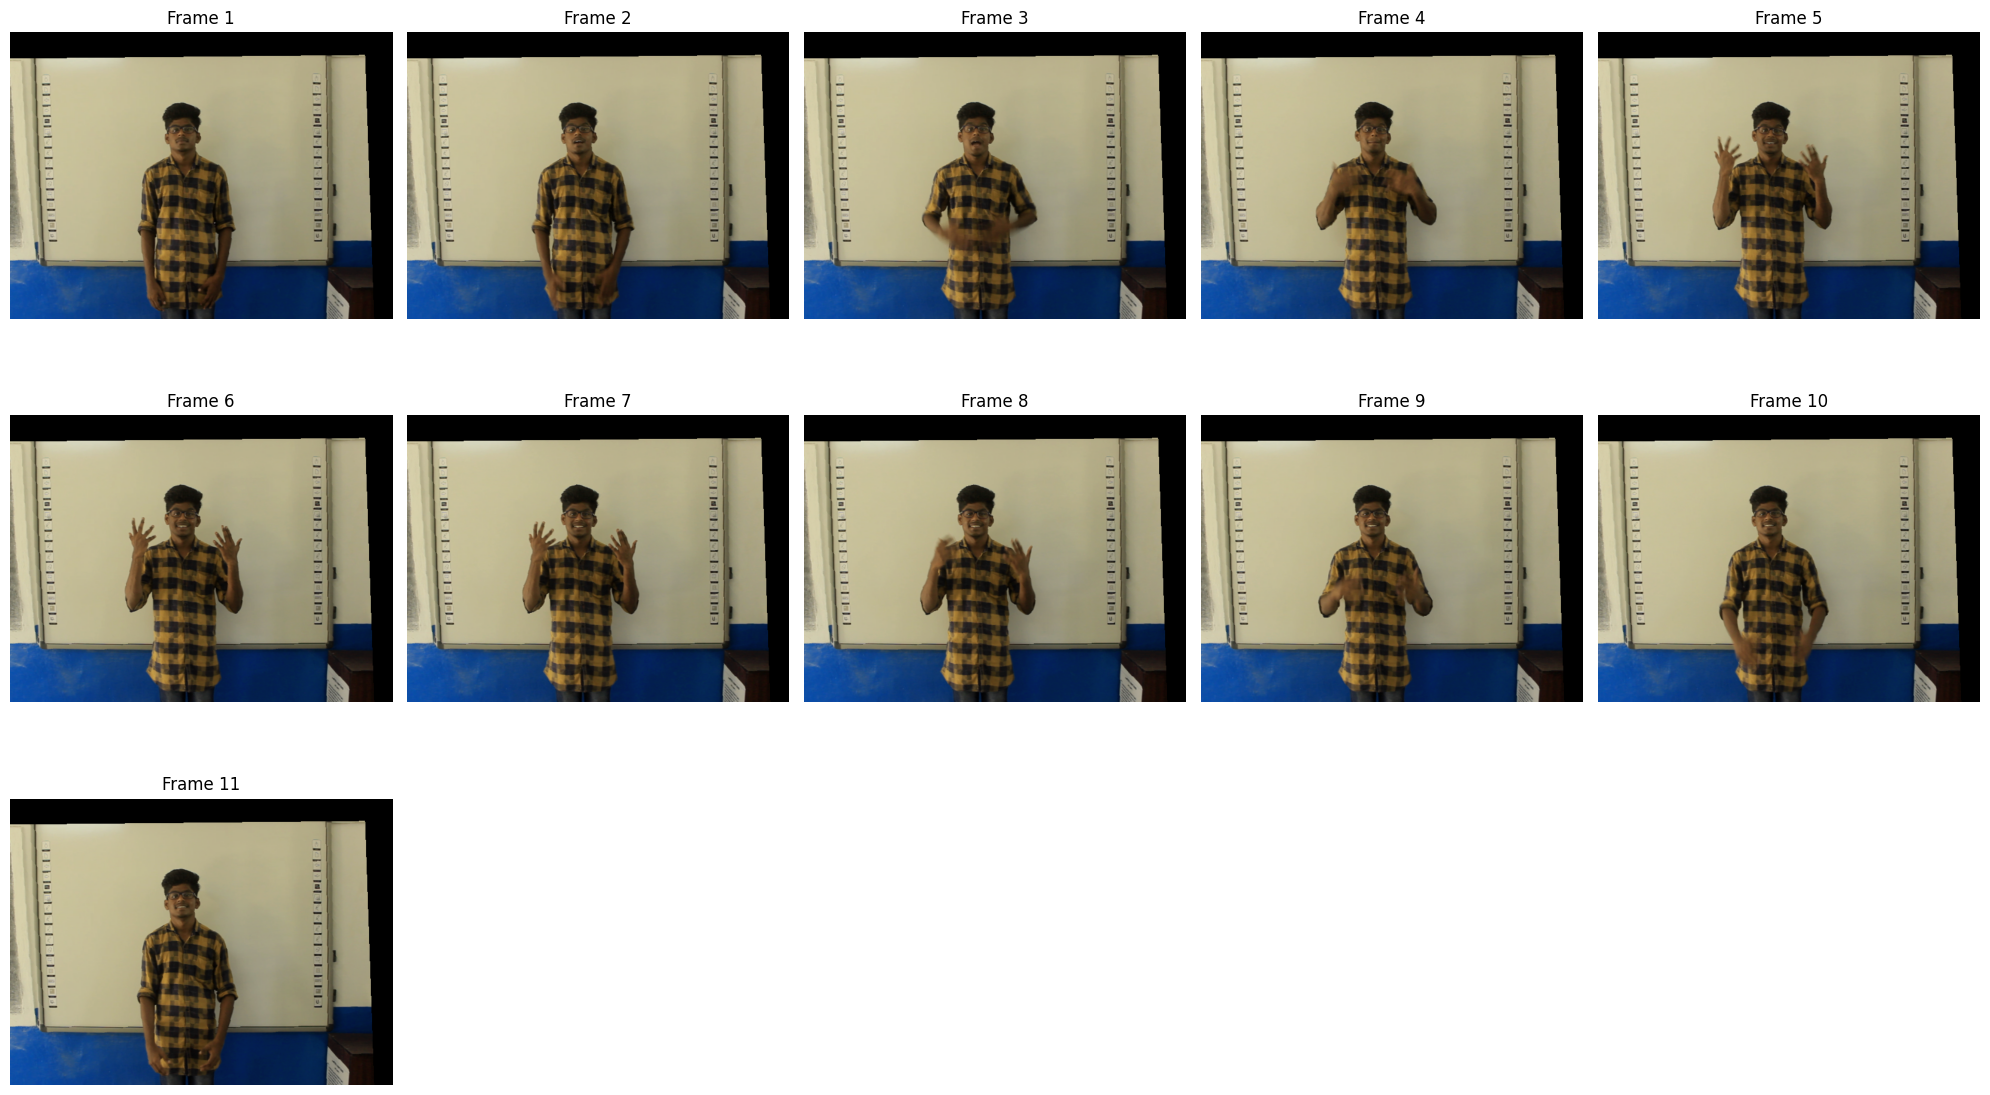

In [48]:
# Calculate the number of rows and columns for the grid
num_frames = len(frames)
cols = 5  # You can adjust the number of columns
rows = (num_frames + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))  # Adjust figure size as needed

for i, frame in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(frame.permute(1,2,0))
    plt.title(f"Frame {i+1}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [49]:
import math
import random

In [50]:
def temporal_transform(frames):
  # Time warping
  step = random.choice(range(4, 10))
  frames = frames[::step]

  # Time Jiterring

  # Frame Dropping
  drop_prob = 0.1
  keep = [frame for frame in frames if random.random() > drop_prob]
  if len(keep) > 3:
    frames = torch.stack(keep)

  # Frame Mask
  mask_prob = 0.1
  idx = random.choices(range(frames.shape[0]), k=int(frames.shape[0]*mask_prob))
  frames[idx] = torch.zeros_like(frames[idx])

  return frames

In [56]:
train_files, test_files = train_test_files_split(data_path, test_ratio=0.2)

train_dataset = HandGestureDataset(
    train_files,
    frame_transform=frame_transform,
    temporal_transform=temporal_transform,
    # landmark_transform=landmark_transform,
    max_augments=50,
    # saved_data_path=data_path,
    # train=True
)

test_dataset = HandGestureDataset(
    test_files,
    # saved_data_path=data_path
)

In [57]:
len(train_dataset), len(test_dataset)

(8856, 851)

In [58]:
train_dataset[10][0].shape, train_dataset[10][1]

(torch.Size([12, 67, 3]), 'Team')

In [59]:
# Create DataLoaders for the training and testing datasets
# Set num_workers to 0 to avoid CUDA re-initialization issues with multiprocessing
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=video_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=video_collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 8856
Testing dataset size: 851


In [60]:
import gc

In [ ]:
for i, (x_batch, y_batch) in enumerate(train_dataloader):
  print(f"{i}.", "Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  gc.collect()
  # break

In [ ]:
 for i, (x_batch, y_batch) in enumerate(test_dataloader):
  print(f"{i}.", "Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  gc.collect()   
  # break

Saving Preprocessed Dataset

In [ ]:
def collect_data(dataset):
  # collected all data to store
  all_features = []
  all_labels = []

  for x, y in dataset:
    all_features.append(x)
    all_labels.append(y)

  all_data = (all_features, all_labels)
  return all_data

In [ ]:
# Save the cached data with .pth extension
save_directory = '/kaggle/working/'
save_data_path = os.path.join(save_directory, 'preprocessed_video_INCLUDE_data.pth')

combined_data = {
  'train': collect_data(train_dataset),
  'test': collect_data(test_dataset)
}

torch.save(combined_data, save_data_path)

Data Visualization

In [61]:
skeleton_edges = [
    # Left Hand
    (0, 1), (1, 2), (2, 3), (3, 4), # thumb
    (0, 5), (5, 6), (6, 7), (7, 8), # index
    (0, 9), (9, 10), (10, 11), (11, 12), # middle
    (0, 13), (13, 14), (14, 15), (15, 16), # ring
    (0, 17), (17, 18), (18, 19), (19, 20), # pinky

    # Right Hand
    (21, 22), (22, 23), (23, 24), (24, 25), # thumb
    (21, 26), (26, 27), (27, 28), (28, 29), # index
    (21, 30), (30, 31), (31, 32), (32, 33), # middle
    (21, 34), (34, 35), (35, 36), (36, 37), # ring
    (21, 38), (38, 39), (39, 40), (40, 41), # pinky

    # Pose
    (53, 55), (55, 57), # Left Arm
    (54, 56), (56, 58), # Right Arm
    (53, 54),             # Shoulders
    (53, 65), (54, 66),   # Torso
    (65, 66),             # Hips
    (42, 53), (42, 54),   # Nose to Shoulders
    # (66, 68), (68, 70),   # Hips to Left Leg
    # (65, 67), (67, 69),   # Hips to Right Leg

    # (0, 57), (21, 58) # Hands wrist to Pose wrist
]

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_frame_landmarks(frame_data_list, skeleton_edges):
  """
  Visualizes the landmarks for a list of frames in 3D subplots.

  Args:
    frame_data_list (list): A list of torch.Tensor, where each tensor is of shape
                            [num_landmarks, 3] containing the x, y, z coordinates
                            of landmarks for a single frame.
    skeleton_edges (list): A list of tuples representing connections between landmarks.
  """
  num_frames = len(frame_data_list)
  cols = 5 # Number of columns in the subplot grid
  rows = (num_frames + cols - 1) // cols # Calculate number of rows

  fig = plt.figure(figsize=(cols * 3, rows * 3))

  for i, frame_data in enumerate(frame_data_list):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

    # Plot the landmarks
    ax.scatter(frame_data[:21, 0], frame_data[:21, 1], frame_data[:21, 2], marker='o')
    ax.scatter(frame_data[21:42, 0], frame_data[21:42, 1], frame_data[21:42, 2], marker='_')
    ax.scatter(frame_data[42, 0], frame_data[42, 1], frame_data[42, 2], marker='*')
    ax.scatter(frame_data[43:75, 0], frame_data[43:75, 1], frame_data[43:75, 2], marker='.')
    ax.scatter(frame_data[75:, 0], frame_data[75:, 1], frame_data[75:, 2], marker='x')

    # Plot the connections (skeleton)
    for k, l in skeleton_edges:
      x = [frame_data[k, 0], frame_data[l, 0]]
      y = [frame_data[k, 1], frame_data[l, 1]]
      z = [frame_data[k, 2], frame_data[l, 2]]
      ax.plot(x, y, z, 'blue')

    ax.set_title(f'Frame {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.gca().invert_zaxis()

  plt.tight_layout()
  plt.show()

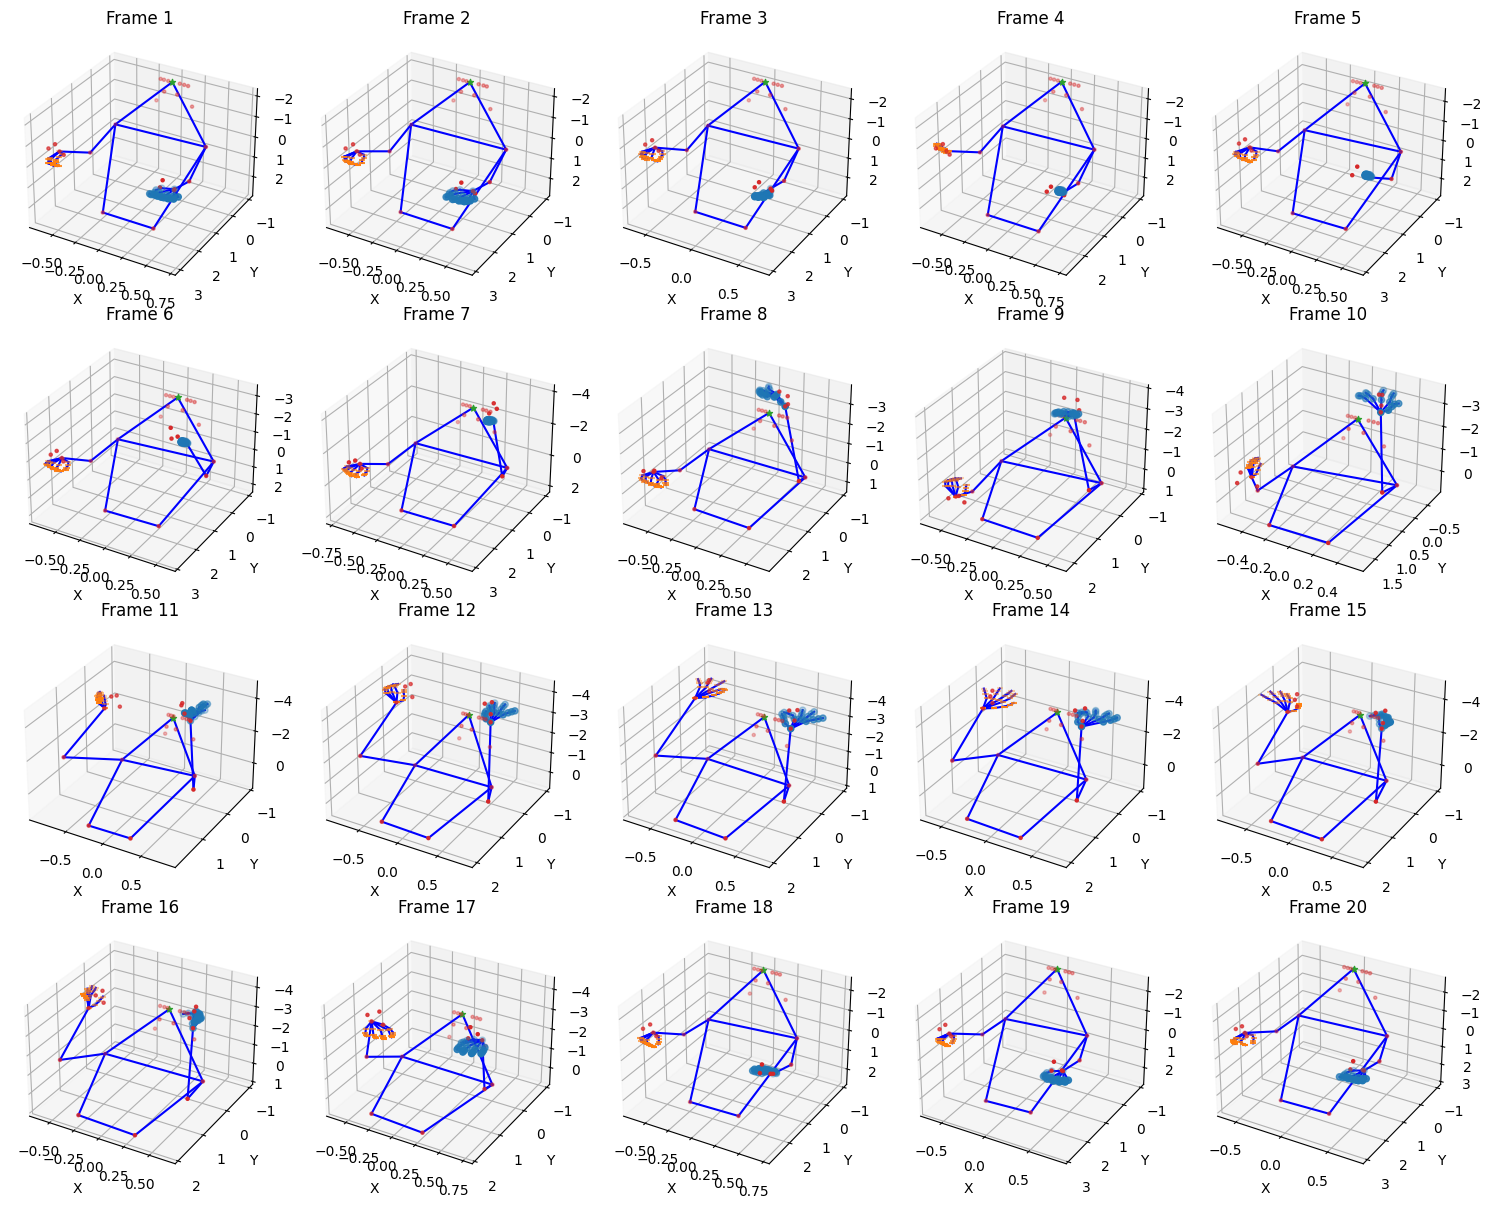

How are you


In [65]:
# Example usage: Visualize the first frame of the first video in the dataset
# Assuming dataset[0][0] is the first video and has shape [num_frames, num_landmarks, 3]
frames = train_dataset[200][0] # Get the first frame
visualize_frame_landmarks(frames, skeleton_edges)
print(train_dataset[200][1])

In [67]:
# right hand wrist
frames[10][21], frames[10][57]

(tensor([-0.5547,  0.4676, -3.6027], dtype=torch.float64),
 tensor([ 0.4948,  0.2155, -3.8184], dtype=torch.float64))